# Kaggle Project-1
# Brain Tumor MRI Classification
- 출처: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
- 목표: ImageDataGenerator와 TL(transfer learning)을 이용해서 과대적합을 최소화하여 90%이상의 정확도 달성
  - 만약 목표를 달성하지 못한다면, 문제점과 해결 방안 모색

## Dataset

In [ ]:
# 구글 마운트
# Google mount
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 현재 디렉토리 /content로 이미지 데이터 복사 후 현재 디렉토리 ROOT_DIR로 명명
# Copy image data to /content and name /content as ROOT_DIR
import shutil
shutil.copy("/content/drive/MyDrive/Colab Notebooks/brain_tumor.zip", "/content")
ROOT_DIR = "/content"

In [ ]:
# brain_tumor 디렉토리 생성과 동시에 압축해제 후 brain_tumor 디렉토리 DATA_ROOT_DIR로 명명
# Decompress data in brain_tumor dir and name brain_tumor dir as DATA_ROOT_DIR
import zipfile
with zipfile.ZipFile("/content/brain_tumor.zip", "r") as target_file:
  target_file.extractall("/content/brain_tumor")
  DATA_ROOT_DIR = "/content/brain_tumor"

## Path naming

In [ ]:
# brain_tumor 디렉토리에 Testing과 Training 디렉토리 확인 후
# 각각 TEST_DATA_ROOT_DIR, TRIAN_DATA_ROOT_DIR로 명명
# Name Testing dir and Training dir in brain_tumor dir as TEST_DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR
TRAIN_DATA_ROOT_DIR = "/content/brain_tumor/Training"
TEST_DATA_ROOT_DIR = "/content/brain_tumor/Testing"

## Checking total number of data and labels

In [ ]:
# 훈련 데이터 개수 파악
# number of Training data
import os
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for train_label_name in train_label_name_list:
  print(train_label_name, "=>", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_label_name))))

['pituitary_tumor', 'glioma_tumor', 'no_tumor', 'meningioma_tumor']
pituitary_tumor => 827
glioma_tumor => 826
no_tumor => 395
meningioma_tumor => 822


In [ ]:
# 테스트 데이터 개수 파악
# number of Testing data
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for test_label_name in test_label_name_list:
  print(test_label_name, "=>", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_label_name))))

['pituitary_tumor', 'glioma_tumor', 'no_tumor', 'meningioma_tumor']
pituitary_tumor => 74
glioma_tumor => 100
no_tumor => 105
meningioma_tumor => 115


## Setting image shape

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

## Importing data using ImageDataGenerator

In [ ]:
# ImageDataGenerator에 정규화 기능 추가
# Add normalizing function in ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 색상, 크기, 레이블 타입 인코딩 설정
# setting image size, color mode and integer type encoding
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR,
                                                    batch_size = 32,
                                                    color_mode="rgb",
                                                    class_mode="sparse",
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))
test_generator = train_datagen.flow_from_directory(TEST_DATA_ROOT_DIR,
                                                   batch_size = 32,
                                                   color_mode="rgb",
                                                   class_mode="sparse",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
# 레이블과 레이블 개수 확인
# checking labels and the number of labels

print(train_generator.class_indices, train_generator.num_classes)
print(test_generator.class_indices, test_generator.num_classes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3} 4
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3} 4


## 32장의 이미지 확인
- ImageDataGenerator로 전달 된 이미지 확인

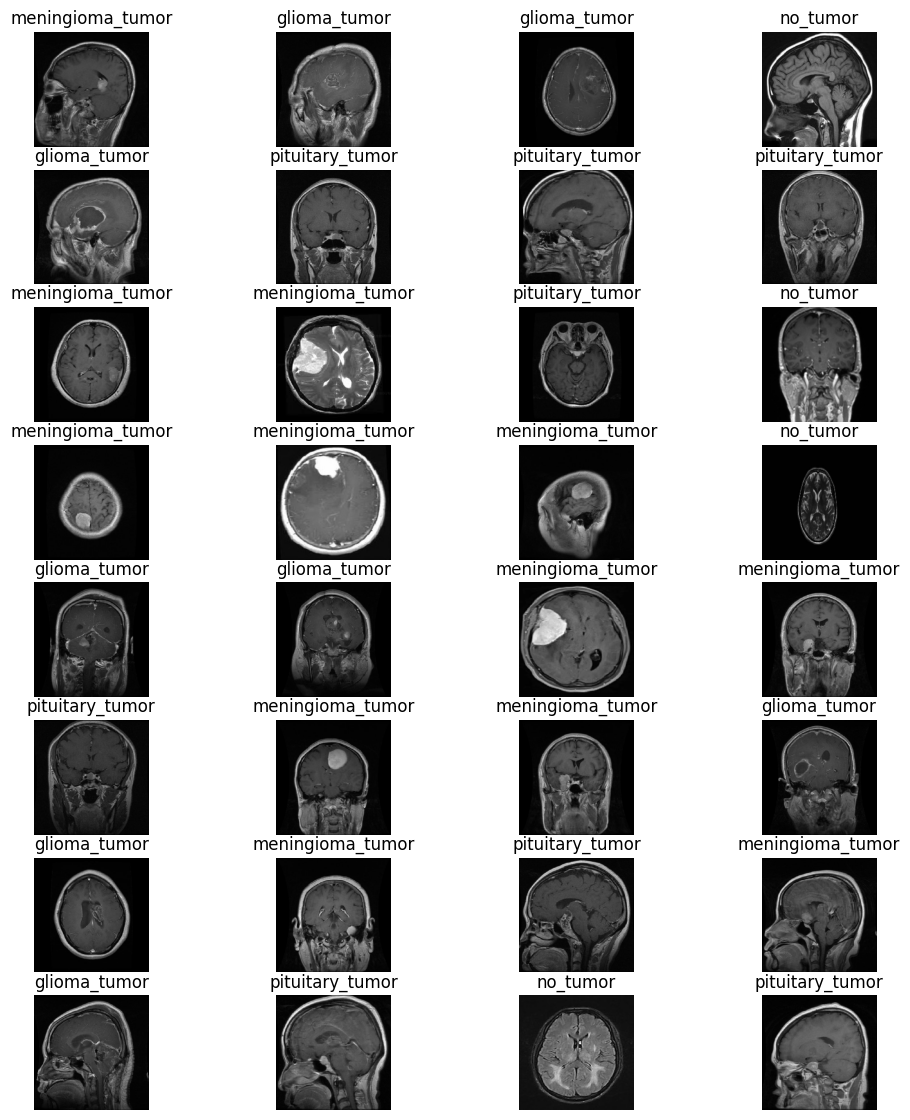

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 14))

images_32 = train_generator.next()
for i in range(len(images_32[1])):
  plt.subplot(8, 4, i+1)
  plt.imshow(images_32[0][i])
  plt.title(list(train_generator.class_indices.keys())[int(images_32[1][i])])
  plt.axis("off")

## Transfer learning

In [ ]:
# fine tunning을 위한 학습된 모델 구축(MobileNet)
# Establishing pre-trained model(MobileNet) for fine tunning
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNet, Xception

pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
#fine tunning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

In [ ]:
# 학습 시작
# Training

from datetime import datetime

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data=test_generator)

end_time = datetime.now()
print("ELapsed Time :", end_time - start_time)

Epoch 1/30
90/90 [==============================] - 45s 226ms/step - loss: 1.6265 - accuracy: 0.3251 - val_loss: 1.4494 - val_accuracy: 0.3020
Epoch 2/30
90/90 [==============================] - 17s 188ms/step - loss: 1.2037 - accuracy: 0.4916 - val_loss: 1.2449 - val_accuracy: 0.3579
Epoch 3/30
90/90 [==============================] - 18s 204ms/step - loss: 0.9299 - accuracy: 0.6213 - val_loss: 1.1654 - val_accuracy: 0.4924
Epoch 4/30
90/90 [==============================] - 19s 206ms/step - loss: 0.7808 - accuracy: 0.6847 - val_loss: 1.1248 - val_accuracy: 0.5406
Epoch 5/30
90/90 [==============================] - 18s 202ms/step - loss: 0.6592 - accuracy: 0.7449 - val_loss: 1.1056 - val_accuracy: 0.5584
Epoch 6/30
90/90 [==============================] - 18s 199ms/step - loss: 0.6017 - accuracy: 0.7672 - val_loss: 1.0812 - val_accuracy: 0.5838
Epoch 7/30
90/90 [==============================] - 22s 244ms/step - loss: 0.5083 - accuracy: 0.8080 - val_loss: 1.0216 - val_accuracy: 0.6396

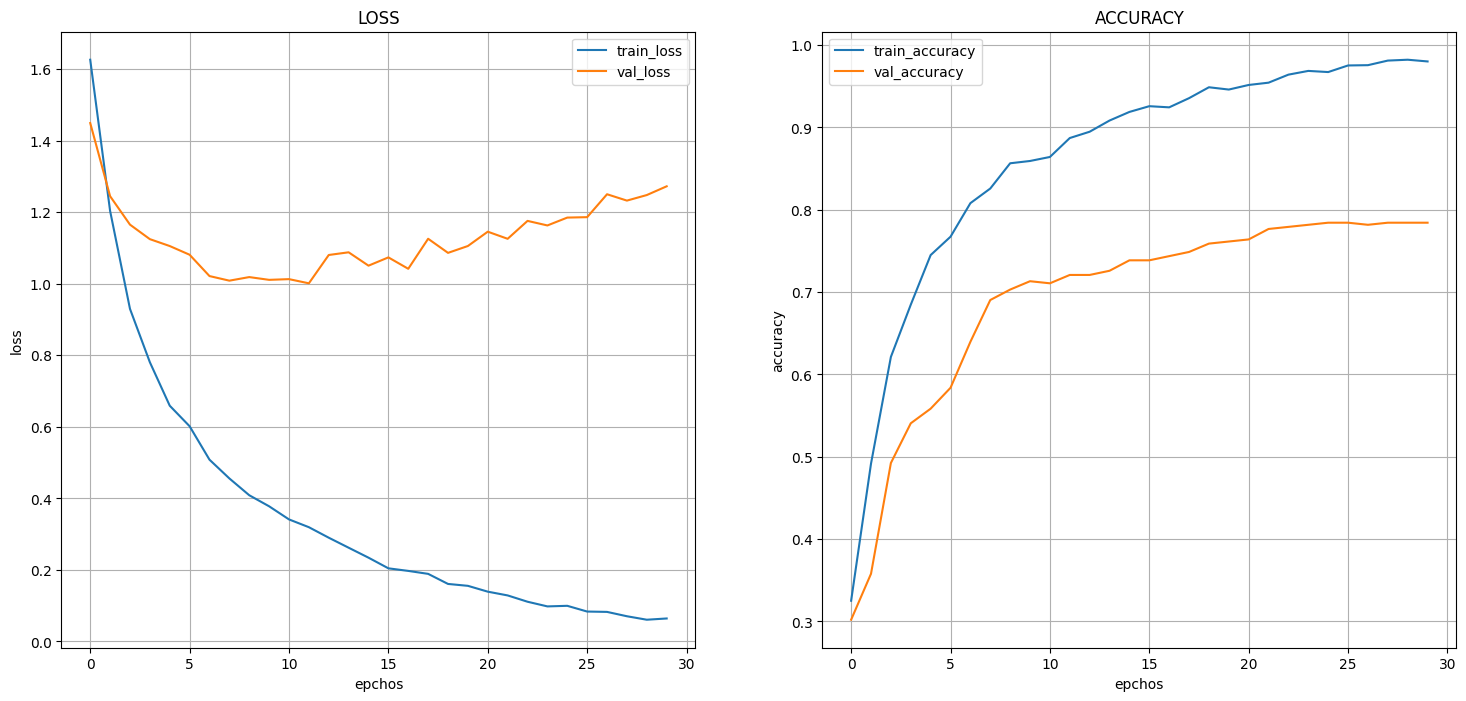

In [ ]:
# 학습 결과 시각화
# Visualizing training result

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epchos")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="val_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epchos")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="val_accuracy")
plt.legend(loc="best")

## 문제점 Problems
- 과대적합이 심각하고 val_loss 값도 더이상 감소하지 않는 추세이다
- We can clearly see that there is overfitting and val_loss isnt't decreasing

## 해결방안 Solution
- 과대적합이 심각해 보이므로 데이터 쏠림 현상이 있는지 의심된다. 그러므로 Training 데이터와 Testing 데이터를 섞은 후 재분배하여 과대적합 문제를 해결한다.
- The overfitting seems severe, so it is questionable whether there is a data bias. Therefore, we can try solving the overfitting problem by mixing and redistributing the training data and testing data.

In [ ]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

In [ ]:
for test_label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, test_label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num = move_num + 1
    print(str(move_num) + " files have been moved into " + label_name + "(Testing => Training)")

In [ ]:
for train_label_name in train_label_name_list:
    print(train_label_name, len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_label_name))))

In [ ]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

In [ ]:
# move할 파일의 비율
MOVE_PATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("=================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!!!")

    split_num = int(MOVE_PATIO * len(train_data_file_list))
    print("split_num =>", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("total move num => ", move_num)
    print("=================================================")